In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Load Data:

In [2]:
train_df = pd.read_csv(r'C:\Users\nisar2\Box\Stat 542\Stat 542 Project\data\fashion-mnist_train.csv')
test_df = pd.read_csv(r'C:\Users\nisar2\Box\Stat 542\Stat 542 Project\data\fashion-mnist_test.csv')

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Make data numpy arrrays:

In [4]:
X_train = np.array(train_df, dtype=np.float64)[:,1:]
X_test = np.array(test_df, dtype=np.float64)[:,1:]
y_train = np.array(train_df['label'], dtype=np.float64)
y_test = np.array(test_df['label'], dtype=np.float64)

## Standardize data (mean=0, std=1) using StandardScaler

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Transform data using PCA 

In [6]:
pca = PCA(.90)
pca.fit(X_train_scaled)

X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train_PCA.shape, y_train.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)
(60000, 137) (60000,)


In [8]:
def plot_confusion(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='x-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.xticks([0,1,2,3,4,5,6,7,8,9])
    plt.yticks([0,1,2,3,4,5,6,7,8,9])
    plt.title(title, fontsize=12)
    plt.show()

## KNN:

### Experiement:

In [9]:
k = np.arange(1,10,2).astype('int')
parameters = {'n_neighbors': k}

neigh = KNeighborsClassifier()
neigh_clf = GridSearchCV(neigh, parameters)
neigh_clf.fit(X_train_PCA, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 3, 5, 7, 9])})

In [10]:
neigh_preds = neigh_clf.predict(X_test_PCA)
neigh_score = neigh_clf.score(X_test_PCA, y_test)

In [11]:
neigh_class_report = classification_report(y_test, neigh_preds)
neigh_confusion_matrix = confusion_matrix(y_test, neigh_preds)

### Results: 

In [12]:
print(neigh_score)
print(neigh_clf.best_estimator_)
print(neigh_class_report)

0.8669
KNeighborsClassifier(n_neighbors=7)
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.80      0.77      0.78      1000
         3.0       0.90      0.89      0.90      1000
         4.0       0.78      0.82      0.80      1000
         5.0       0.98      0.89      0.93      1000
         6.0       0.69      0.63      0.66      1000
         7.0       0.90      0.93      0.91      1000
         8.0       0.98      0.95      0.96      1000
         9.0       0.90      0.96      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



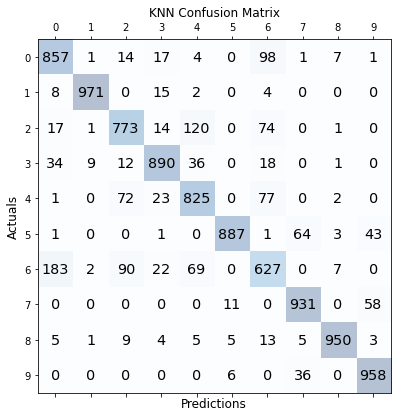

In [13]:
plot_confusion(neigh_confusion_matrix, "KNN Confusion Matrix")

## Light GBM

In [14]:
lgbm = LGBMClassifier(n_estimators = 500)
lgbm.fit(X_train_PCA, y_train)


LGBMClassifier(n_estimators=500)

In [15]:
lgbm.score(X_test_PCA, y_test)

0.8946

In [16]:
num_leaves = [20,40,60]
n_estimators = [100,500,1000]
parameters = {
    'num_leaves': num_leaves,
    'n_estimators': n_estimators
}

lgbm = LGBMClassifier()
lgbm_clf = GridSearchCV(lgbm, parameters)
lgbm_clf.fit(X_train_PCA, y_train)

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'n_estimators': [100, 500, 1000],
                         'num_leaves': [20, 40, 60]})

In [17]:
lgbm_preds = lgbm_clf.predict(X_test_PCA)
lgbm_score = lgbm_clf.score(X_test_PCA, y_test)

In [18]:
lgbm_class_report = classification_report(y_test, lgbm_preds)
lgbm_confusion_matrix = confusion_matrix(y_test, lgbm_preds)

In [19]:
print(lgbm_score)
print(lgbm_clf.best_estimator_)
print(lgbm_class_report)

0.8988
LGBMClassifier(n_estimators=1000, num_leaves=40)
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85      1000
         1.0       0.99      0.98      0.98      1000
         2.0       0.84      0.83      0.83      1000
         3.0       0.91      0.92      0.92      1000
         4.0       0.83      0.87      0.85      1000
         5.0       0.97      0.95      0.96      1000
         6.0       0.76      0.68      0.72      1000
         7.0       0.93      0.95      0.94      1000
         8.0       0.97      0.98      0.97      1000
         9.0       0.94      0.96      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



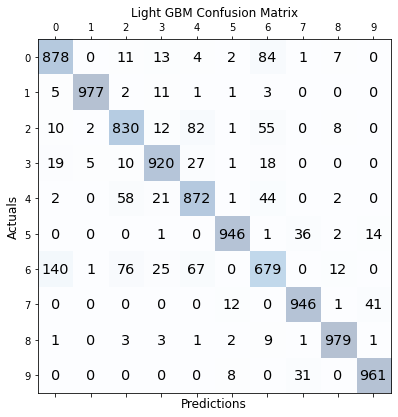

In [20]:
plot_confusion(lgbm_confusion_matrix, "Light GBM Confusion Matrix")

## Logistic Regression:

In [21]:
C = np.arange(0,2,.3)
print(C)
parameters = {'C': C}

log_reg = LogisticRegression(
    multi_class='multinomial', 
    max_iter=100,
    random_state=0, 
    fit_intercept=False,
    solver='lbfgs',
    tol=1e-3
)

log_reg_clf = GridSearchCV(log_reg, parameters)
log_reg_clf.fit(X_train_PCA, y_train)

[0.  0.3 0.6 0.9 1.2 1.5 1.8]


C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:811: RuntimeWarning: divide by zero encountered in double_scalars
  args=(X, target, 1.0 / C, sample_weight),
C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:301: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * alpha * squared_norm(w)
C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:352: RuntimeWarning: invalid value encountered in multiply
  grad[:, :n_features] += alpha * w
C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nisar2\Anaconda3\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

GridSearchCV(estimator=LogisticRegression(fit_intercept=False,
                                          multi_class='multinomial',
                                          random_state=0, tol=0.001),
             param_grid={'C': array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8])})

In [22]:
log_reg_preds = log_reg_clf.predict(X_test_PCA)
log_reg_score = log_reg_clf.score(X_test_PCA, y_test)

In [23]:
log_reg_class_report = classification_report(y_test, log_reg_preds)
log_reg_confusion_matrix = confusion_matrix(y_test, log_reg_preds)

0.8527
LogisticRegression(C=0.8999999999999999, fit_intercept=False,
                   multi_class='multinomial', random_state=0, tol=0.001)
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81      1000
         1.0       0.97      0.97      0.97      1000
         2.0       0.77      0.77      0.77      1000
         3.0       0.86      0.88      0.87      1000
         4.0       0.78      0.80      0.79      1000
         5.0       0.92      0.92      0.92      1000
         6.0       0.65      0.59      0.62      1000
         7.0       0.90      0.91      0.90      1000
         8.0       0.95      0.93      0.94      1000
         9.0       0.93      0.94      0.93      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



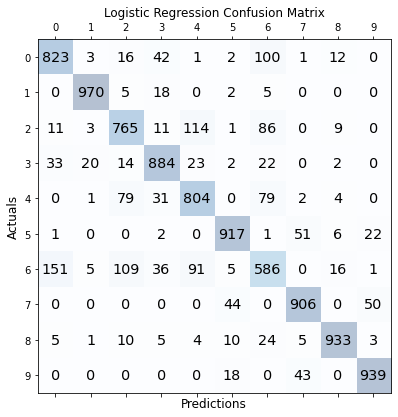

In [24]:
print(log_reg_score)
print(log_reg_clf.best_estimator_)
print(log_reg_class_report)
plot_confusion(log_reg_confusion_matrix, "Logistic Regression Confusion Matrix")